
# TP : Prédire le prix de location de logements à Antananarivo avec une régression linéaire multiple

## 🎯 Objectifs pédagogiques

- Appliquer un pipeline de prétraitement complet sur un jeu de données semi-structuré.
- Gérer les variables qualitatives, les valeurs manquantes, la multicolinéarité et la scalabilité.
- Construire, tester et évaluer un modèle de régression linéaire multiple.
- Déployer le modèle dans une application Python Streamlit avec interface utilisateur.

## 🗂️ Jeu de données

Le jeu de données doit être collecté ou scrappé dans les pages comme Facebook. Il doit comporter les colonnes suivantes :

- `quartier` (catégorielle)
- `superficie` (numérique)
- `nombre_chambres` (numérique)
- `douche_wc`(interieur ou exterieur)
- `type_d_acces` (sans, moto, voiture, voiture_avec_par_parking)
- `meublé` (booléen:  oui ou non)
- `état_général` (catégorielle : bon, moyen, mauvais)
- `loyer_mensuel` (target)

## 🧪 Étapes du TP

### 📌 Partie 1 : Préparation des données
- Lecture du dataset brut
- Gestion des valeurs manquantes
- Encodage des variables catégorielles
- Création de variables dérivées
- Détection et suppression des variables fortement corrélées
- Standardisation et normalisation

### 📌 Partie 2 : Modélisation

- Séparation train/test
- Implémentation de la régression linéaire multiple
- Évaluation : R², RMSE
- Vérification des hypothèses d'élligibilité de la régression linéaire multiple (surtout sur les erreurs)

### 📌 Partie 3 : Optimisation du modèle

- Sélection de variables : backward elimination, RFE (à documenter)

### 📌 Partie 4 : Déploiement d’une application Streamlit

- Interface de saisi utilisateur
- Affichage du loyer prédit
- Visualisation des poids des variables
- Affichage sur la carte interactive

## 🧭 Carte interactive (option avancée)

Utiliser `streamlit-folium` pour permettre à l’utilisateur de cliquer sur une carte et de récupérer les coordonnées GPS. À partir de ces coordonnées, déterminer automatiquement le quartier en utilisant un fichier GeoJSON ou un système de polygones avec `geopandas`.

## 🔧 Technologies à utiliser

- `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `joblib`
- `streamlit`, `folium`, `streamlit-folium`
- Optionnel : `geopandas`, `shapely`

## 💡 Bonus

- Carte interactive avec folium
- Simuler des données additionnelles (pollution, sécurité)
- Tri automatique des caractéristiques influentes




## 📌 Partie 1 : Préparation des données

In [1]:
import math

# Lecture du dataset brut
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

maison = pd.read_csv("Location de maison Antananarivo  - Données finales - 1.csv")

maison_2 = pd.read_csv("Location de maison Antananarivo  - Données finales - 1.csv")


In [2]:
maison

,quartier,superficie,nombre_chambres,douche_wc,type_d_acces,meublé,état_général,loyer_mensuel
0,Location de maison Antananarivo - Données fin...,NaN,2,interieur,moto,non,moyen,300000.0
1,Andoharanofotsy,NaN,2,interieur,moto,non,mauvais,180000.0
2,Andoharanofotsy,NaN,1,exterieur,moto,non,mauvais,170000.0
3,Andoharanofotsy,NaN,2,exterieur,moto,non,moyen,250000.0
4,Andoharanofotsy,NaN,2,interieur,voiture_avec_parking,non,bon,450000.0
...,...,...,...,...,...,...,...,...
233,andranomahery ankorondrano,600.0,8,interieur,voiture_avec_parking,False,moyen,8806000.0
234,ivandry,250.0,8,interieur,sans,False,moyen,10360000.0
235,ambatobe,500.0,8,interieur,sans,False,moyen,13986000.0
236,ivandry,250.0,5,interieur,voiture,False,moyen,7770000.0


In [3]:
maison.dtypes

quartier            object
superficie          object
nombre_chambres      int64
douche_wc           object
type_d_acces        object
meublé              object
état_général        object
loyer_mensuel      float64
dtype: object

In [4]:
# Transform superficie into float
maison['superficie'] = maison['superficie'].apply(lambda x: x.replace(",", ".") if type(x) == str else x).astype(float)

In [5]:
maison.dtypes

quartier            object
superficie         float64
nombre_chambres      int64
douche_wc           object
type_d_acces        object
meublé              object
état_général        object
loyer_mensuel      float64
dtype: object

In [6]:
maison['meublé'] = maison['meublé'].apply(lambda x: "oui" if x == "True" else ("non" if x == "False" else x))

In [7]:
maison

,quartier,superficie,nombre_chambres,douche_wc,type_d_acces,meublé,état_général,loyer_mensuel
0,Location de maison Antananarivo - Données fin...,NaN,2,interieur,moto,non,moyen,300000.0
1,Andoharanofotsy,NaN,2,interieur,moto,non,mauvais,180000.0
2,Andoharanofotsy,NaN,1,exterieur,moto,non,mauvais,170000.0
3,Andoharanofotsy,NaN,2,exterieur,moto,non,moyen,250000.0
4,Andoharanofotsy,NaN,2,interieur,voiture_avec_parking,non,bon,450000.0
...,...,...,...,...,...,...,...,...
233,andranomahery ankorondrano,600.0,8,interieur,voiture_avec_parking,non,moyen,8806000.0
234,ivandry,250.0,8,interieur,sans,non,moyen,10360000.0
235,ambatobe,500.0,8,interieur,sans,non,moyen,13986000.0
236,ivandry,250.0,5,interieur,voiture,non,moyen,7770000.0


In [8]:
range_etat_general = [
    ("mauvais", 0, 300000),
    ("moyen", 300000, 800000),
    ("bon", 800000, math.inf)
]
maison['état_général'] = maison['loyer_mensuel'].apply(lambda x: range_etat_general[0][0] if range_etat_general[0][1] <= x < range_etat_general[0][2] else (range_etat_general[1][0] if range_etat_general[1][1] <= x < range_etat_general[1][2] else range_etat_general[2][0]))

In [9]:
maison

,quartier,superficie,nombre_chambres,douche_wc,type_d_acces,meublé,état_général,loyer_mensuel
0,Location de maison Antananarivo - Données fin...,NaN,2,interieur,moto,non,moyen,300000.0
1,Andoharanofotsy,NaN,2,interieur,moto,non,mauvais,180000.0
2,Andoharanofotsy,NaN,1,exterieur,moto,non,mauvais,170000.0
3,Andoharanofotsy,NaN,2,exterieur,moto,non,mauvais,250000.0
4,Andoharanofotsy,NaN,2,interieur,voiture_avec_parking,non,moyen,450000.0
...,...,...,...,...,...,...,...,...
233,andranomahery ankorondrano,600.0,8,interieur,voiture_avec_parking,non,bon,8806000.0
234,ivandry,250.0,8,interieur,sans,non,bon,10360000.0
235,ambatobe,500.0,8,interieur,sans,non,bon,13986000.0
236,ivandry,250.0,5,interieur,voiture,non,bon,7770000.0


In [10]:
# Encoding One-hot douche_wc
one_hot = pd.get_dummies(maison['douche_wc'])
maison = one_hot.join(maison)
maison = maison.drop('douche_wc',axis = 1)

In [11]:
maison

,exterieur,interieur,quartier,superficie,nombre_chambres,type_d_acces,meublé,état_général,loyer_mensuel
0,False,True,Location de maison Antananarivo - Données fin...,NaN,2,moto,non,moyen,300000.0
1,False,True,Andoharanofotsy,NaN,2,moto,non,mauvais,180000.0
2,True,False,Andoharanofotsy,NaN,1,moto,non,mauvais,170000.0
3,True,False,Andoharanofotsy,NaN,2,moto,non,mauvais,250000.0
4,False,True,Andoharanofotsy,NaN,2,voiture_avec_parking,non,moyen,450000.0
...,...,...,...,...,...,...,...,...,...
233,False,True,andranomahery ankorondrano,600.0,8,voiture_avec_parking,non,bon,8806000.0
234,False,True,ivandry,250.0,8,sans,non,bon,10360000.0
235,False,True,ambatobe,500.0,8,sans,non,bon,13986000.0
236,False,True,ivandry,250.0,5,voiture,non,bon,7770000.0


In [12]:
quantile = maison['superficie'].quantile([0.25,0.5,0.75])

In [13]:
quantile

0.25     71.0
0.50    125.0
0.75    250.0
Name: superficie, dtype: float64

In [14]:
# Remplir les valeurs manquantes superficie
maison['superficie'] = maison['superficie'].fillna(maison.apply(lambda x: quantile[0.25] if x['état_général'] == "mauvais" else (quantile[0.5] if x['état_général'] == "moyen" else quantile[0.75]), axis = 1))

In [15]:
# Remplir les valeurs manquantes loyer_mensuel
maison['loyer_mensuel'] = maison['loyer_mensuel'].fillna(maison['loyer_mensuel'].mean())

In [16]:
Q1 = quantile[0.25]
Q3 = quantile[0.75]
IQR_superficie = Q3 - Q1
# Define the lower and upper thresholds
lower_bound = Q1 - 1.5 * IQR_superficie
upper_bound = Q3 + 1.5 * IQR_superficie

maison = maison[(maison['superficie'] > lower_bound) & (maison['superficie'] < upper_bound)]

In [17]:
maison

,exterieur,interieur,quartier,superficie,nombre_chambres,type_d_acces,meublé,état_général,loyer_mensuel
0,False,True,Location de maison Antananarivo - Données fin...,125.0,2,moto,non,moyen,300000.0
1,False,True,Andoharanofotsy,71.0,2,moto,non,mauvais,180000.0
2,True,False,Andoharanofotsy,71.0,1,moto,non,mauvais,170000.0
3,True,False,Andoharanofotsy,71.0,2,moto,non,mauvais,250000.0
4,False,True,Andoharanofotsy,125.0,2,voiture_avec_parking,non,moyen,450000.0
...,...,...,...,...,...,...,...,...,...
228,True,False,tsiadana,220.0,5,voiture_avec_parking,non,bon,5180000.0
229,False,True,tsiadana,250.0,5,voiture_avec_parking,non,bon,6216000.0
234,False,True,ivandry,250.0,8,sans,non,bon,10360000.0
235,False,True,ambatobe,500.0,8,sans,non,bon,13986000.0


In [18]:
quantile_loyer_mensuel = maison['loyer_mensuel'].quantile([0.25,0.5,0.75])

In [19]:
quantile_loyer_mensuel

0.25     600000.0
0.50    1000000.0
0.75    4831000.0
Name: loyer_mensuel, dtype: float64

In [20]:
Q1_loyer = quantile_loyer_mensuel[0.25]
Q3_loyer = quantile_loyer_mensuel[0.75]
IQR_loyer = Q3_loyer - Q1_loyer
# Define the lower and upper thresholds
lower_bound = Q1_loyer - 1.5 * IQR_loyer
upper_bound = Q3_loyer + 1.5 * IQR_loyer

maison = maison[(maison['loyer_mensuel'] > lower_bound) & (maison['loyer_mensuel'] < upper_bound)]

In [21]:
maison

,exterieur,interieur,quartier,superficie,nombre_chambres,type_d_acces,meublé,état_général,loyer_mensuel
0,False,True,Location de maison Antananarivo - Données fin...,125.0,2,moto,non,moyen,300000.0
1,False,True,Andoharanofotsy,71.0,2,moto,non,mauvais,180000.0
2,True,False,Andoharanofotsy,71.0,1,moto,non,mauvais,170000.0
3,True,False,Andoharanofotsy,71.0,2,moto,non,mauvais,250000.0
4,False,True,Andoharanofotsy,125.0,2,voiture_avec_parking,non,moyen,450000.0
...,...,...,...,...,...,...,...,...,...
227,False,True,ivandry,90.0,3,voiture_avec_parking,oui,bon,6216000.0
228,True,False,tsiadana,220.0,5,voiture_avec_parking,non,bon,5180000.0
229,False,True,tsiadana,250.0,5,voiture_avec_parking,non,bon,6216000.0
234,False,True,ivandry,250.0,8,sans,non,bon,10360000.0


In [22]:
# Encoding Ondinal état_général
mapping = {
    "bon": 2,
    "moyen": 1,
    "mauvais": 0
}
pd.set_option('future.no_silent_downcasting', True)
maison['état_général'] = maison['état_général'].replace(mapping)

/tmp/ipykernel_27229/3591011103.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maison['état_général'] = maison['état_général'].replace(mapping)


In [23]:
maison

,exterieur,interieur,quartier,superficie,nombre_chambres,type_d_acces,meublé,état_général,loyer_mensuel
0,False,True,Location de maison Antananarivo - Données fin...,125.0,2,moto,non,1,300000.0
1,False,True,Andoharanofotsy,71.0,2,moto,non,0,180000.0
2,True,False,Andoharanofotsy,71.0,1,moto,non,0,170000.0
3,True,False,Andoharanofotsy,71.0,2,moto,non,0,250000.0
4,False,True,Andoharanofotsy,125.0,2,voiture_avec_parking,non,1,450000.0
...,...,...,...,...,...,...,...,...,...
227,False,True,ivandry,90.0,3,voiture_avec_parking,oui,2,6216000.0
228,True,False,tsiadana,220.0,5,voiture_avec_parking,non,2,5180000.0
229,False,True,tsiadana,250.0,5,voiture_avec_parking,non,2,6216000.0
234,False,True,ivandry,250.0,8,sans,non,2,10360000.0


In [24]:
# Encoding One-hot type_d_acces
one_hot = pd.get_dummies(maison['type_d_acces'])
maison = one_hot.join(maison)
maison = maison.drop('type_d_acces',axis = 1)

In [25]:
maison

,moto,sans,voiture,voiture_avec_parking,exterieur,interieur,quartier,superficie,nombre_chambres,meublé,état_général,loyer_mensuel
0,True,False,False,False,False,True,Location de maison Antananarivo - Données fin...,125.0,2,non,1,300000.0
1,True,False,False,False,False,True,Andoharanofotsy,71.0,2,non,0,180000.0
2,True,False,False,False,True,False,Andoharanofotsy,71.0,1,non,0,170000.0
3,True,False,False,False,True,False,Andoharanofotsy,71.0,2,non,0,250000.0
4,False,False,False,True,False,True,Andoharanofotsy,125.0,2,non,1,450000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
227,False,False,False,True,False,True,ivandry,90.0,3,oui,2,6216000.0
228,False,False,False,True,True,False,tsiadana,220.0,5,non,2,5180000.0
229,False,False,False,True,False,True,tsiadana,250.0,5,non,2,6216000.0
234,False,True,False,False,False,True,ivandry,250.0,8,non,2,10360000.0


In [26]:
# Encoding One-hot type_d_acces
maison['meublé'] = maison['meublé'].fillna("non")
mapping = {
    "oui": 2,
    "non": 1
}
maison['meublé'] = maison['meublé'].replace(mapping)

In [27]:
maison

,moto,sans,voiture,voiture_avec_parking,exterieur,interieur,quartier,superficie,nombre_chambres,meublé,état_général,loyer_mensuel
0,True,False,False,False,False,True,Location de maison Antananarivo - Données fin...,125.0,2,1,1,300000.0
1,True,False,False,False,False,True,Andoharanofotsy,71.0,2,1,0,180000.0
2,True,False,False,False,True,False,Andoharanofotsy,71.0,1,1,0,170000.0
3,True,False,False,False,True,False,Andoharanofotsy,71.0,2,1,0,250000.0
4,False,False,False,True,False,True,Andoharanofotsy,125.0,2,1,1,450000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
227,False,False,False,True,False,True,ivandry,90.0,3,2,2,6216000.0
228,False,False,False,True,True,False,tsiadana,220.0,5,1,2,5180000.0
229,False,False,False,True,False,True,tsiadana,250.0,5,1,2,6216000.0
234,False,True,False,False,False,True,ivandry,250.0,8,1,2,10360000.0


In [28]:
maison_without_quartier = maison.loc[:, maison.columns != 'quartier']

In [29]:
maison_without_quartier

,moto,sans,voiture,voiture_avec_parking,exterieur,interieur,superficie,nombre_chambres,meublé,état_général,loyer_mensuel
0,True,False,False,False,False,True,125.0,2,1,1,300000.0
1,True,False,False,False,False,True,71.0,2,1,0,180000.0
2,True,False,False,False,True,False,71.0,1,1,0,170000.0
3,True,False,False,False,True,False,71.0,2,1,0,250000.0
4,False,False,False,True,False,True,125.0,2,1,1,450000.0
...,...,...,...,...,...,...,...,...,...,...,...
227,False,False,False,True,False,True,90.0,3,2,2,6216000.0
228,False,False,False,True,True,False,220.0,5,1,2,5180000.0
229,False,False,False,True,False,True,250.0,5,1,2,6216000.0
234,False,True,False,False,False,True,250.0,8,1,2,10360000.0


In [30]:
correlation = maison_without_quartier.corr()

In [31]:
correlation = correlation['loyer_mensuel'].abs().sort_values()

In [32]:
correlation

voiture_avec_parking    0.040356
voiture                 0.045448
exterieur               0.089709
interieur               0.089709
nombre_chambres         0.109710
sans                    0.160616
moto                    0.308579
meublé                  0.406039
état_général            0.469073
superficie              0.472599
loyer_mensuel           1.000000
Name: loyer_mensuel, dtype: float64

<Axes: >

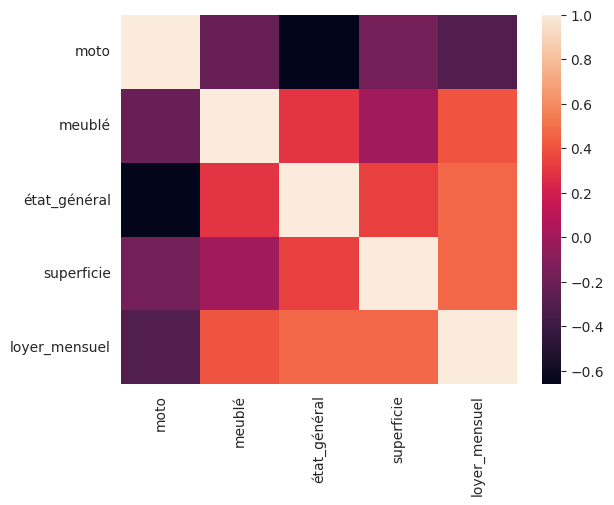

In [33]:
import seaborn as sns
strong_corr = correlation[(correlation > 0.3)]
corrmat = maison_without_quartier[strong_corr.index].corr()
sns.heatmap(corrmat)

In [34]:
# Normalisation
target = "loyer_mensuel"
features = corrmat.drop([target]).index
maison_normalisation = (maison_without_quartier[features].astype(float) - maison_without_quartier[features].min().astype(float)) / (maison_without_quartier[features].max().astype(float) - maison_without_quartier[features].min().astype(float))
#maison_normalisation = maison_without_quartier[features]

In [35]:
maison_normalisation.var().sort_values()

superficie      0.025817
état_général    0.116275
moto            0.117362
meublé          0.177990
dtype: float64

In [36]:
variance_sorted = maison_normalisation.var().sort_values()

In [37]:
variance_sorted

superficie      0.025817
état_général    0.116275
moto            0.117362
meublé          0.177990
dtype: float64

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def superficie_into_float(df):
    df['superficie'] = df['superficie'].apply(lambda x: x.replace(",", ".") if type(x) == str else x).astype(float)
    return df

def meuble_into_oui_non(df):
    df['meublé'] = df['meublé'].apply(lambda x: "oui" if x == "True" else ("non" if x == "False" else x))
    return df

def loyer_mensuel_fillna(df):
    df['loyer_mensuel'] = df['loyer_mensuel'].fillna(df['loyer_mensuel'].mean())
    return df

def etat_general_into_bon_mauvais_moyen(df):
    etat_general = [
        ("mauvais", 0, 300000),
        ("moyen", 300000, 800000),
        ("bon", 800000, math.inf)
    ]
    df['état_général'] = df['loyer_mensuel'].apply(lambda x: etat_general[0][0] if etat_general[0][1] <= x < etat_general[0][2] else (etat_general[1][0] if etat_general[1][1] <= x < etat_general[1][2] else etat_general[2][0]))
    return df

def douche_wc_separate(df):
    one_hot_douche_wc = pd.get_dummies(df['douche_wc'])
    df = one_hot_douche_wc.join(df)
    return df.drop('douche_wc',axis = 1)

def superficie_fillna(df):
    quantile_superficie = df['superficie'].quantile([0.25,0.5,0.75])
    df['superficie'] = df['superficie'].fillna(df.apply(lambda x: quantile_superficie[0.25] if x['état_général'] == "mauvais" else (quantile_superficie[0.5] if x['état_général'] == "moyen" else quantile_superficie[0.75]), axis = 1))
    return df

def aberrante_value_superficie(df):
    quantile_superficie = df['superficie'].quantile([0.25,0.5,0.75])
    Q1_superficie = quantile_superficie[0.25]
    Q3_superficie = quantile_superficie[0.75]
    IQR_super = Q3_superficie - Q1_superficie
    # Define the lower and upper thresholds
    lower_bound_superficie = Q1_superficie - 1.5 * IQR_super
    upper_bound_superficie = Q3_superficie + 1.5 * IQR_super
    return df[(df['superficie'] > lower_bound_superficie) & (df['superficie'] < upper_bound_superficie)]

def aberrante_value_loyer_mensuel(df):
    quantile_loyer = df['loyer_mensuel'].quantile([0.25,0.5,0.75])
    Q1_loyer_mensuel = quantile_loyer[0.25]
    Q3_loyer_mensuel = quantile_loyer[0.75]
    IQR_loyer_mensuel = Q3_loyer_mensuel - Q1_loyer_mensuel
    # Define the lower and upper thresholds
    lower_bound_loyer_mensuel = Q1_loyer_mensuel - 1.5 * IQR_loyer_mensuel
    upper_bound_loyer_mensuel = Q3_loyer_mensuel + 1.5 * IQR_loyer_mensuel
    return df[(df['loyer_mensuel'] > lower_bound_loyer_mensuel) & (df['loyer_mensuel'] < upper_bound_loyer_mensuel)]

def etat_general_into_numerical(df):
    mapping_etat_general = {
        "bon": 3,
        "moyen": 2,
        "mauvais": 1
    }
    pd.set_option('future.no_silent_downcasting', True)
    df['état_général'] = df['état_général'].replace(mapping_etat_general)
    return df

def type_d_acces_separate(df):
    one_hot_type_acces = pd.get_dummies(df['type_d_acces'])
    df = one_hot_type_acces.join(df)
    return df.drop('type_d_acces',axis = 1)

def meuble_into_numerical(df):
    df['meublé'] = df['meublé'].fillna("non")
    mapping_meuble = {
        "oui": 2,
        "non": 1
    }
    df['meublé'] = df['meublé'].replace(mapping_meuble)
    return df

def quartier_remove(df):
    return df.loc[:, df.columns != 'quartier']

def standardization(df):
    correlation_norm = df.corr()
    correlation_norm = correlation_norm[target].abs().sort_values()
    strong_corr_norm = correlation_norm[(correlation_norm > 0.3)]
    corr_math_norm = df[strong_corr_norm.index].corr()
    features_standardization = corr_math_norm.index
    return scaler.fit_transform(df[features_standardization])

def pre_treatment(df):
    df_pre_trait = superficie_into_float(df)
    df_pre_trait = meuble_into_oui_non(df_pre_trait)
    df_pre_trait = loyer_mensuel_fillna(df_pre_trait)
    df_pre_trait = etat_general_into_bon_mauvais_moyen(df_pre_trait)
    df_pre_trait = douche_wc_separate(df_pre_trait)
    df_pre_trait = superficie_fillna(df_pre_trait)
    df_pre_trait = aberrante_value_superficie(df_pre_trait)
    df_pre_trait = aberrante_value_loyer_mensuel(df_pre_trait)
    df_pre_trait = etat_general_into_numerical(df_pre_trait)
    df_pre_trait = type_d_acces_separate(df_pre_trait)
    df_pre_trait = meuble_into_numerical(df_pre_trait)
    y_targ = df_pre_trait[target]
    df_pre_trait = quartier_remove(df_pre_trait)
    df_pre_trait = standardization(df_pre_trait)
    return df_pre_trait, y_targ

In [39]:
columns = variance_sorted[(variance_sorted > 0.05)].index
maison_normalisation = maison_normalisation[columns]

In [40]:
columns

Index(['état_général', 'moto', 'meublé'], dtype='object')

In [41]:
maison_normalisation

,état_général,moto,meublé
0,0.5,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.5,0.0,0.0
...,...,...,...
227,1.0,0.0,1.0
228,1.0,0.0,0.0
229,1.0,0.0,0.0
234,1.0,0.0,0.0


<Axes: >

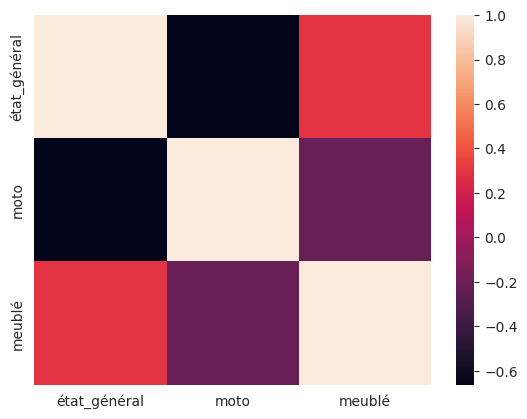

In [42]:
sns.heatmap(maison_normalisation.corr())

In [43]:
columns

Index(['état_général', 'moto', 'meublé'], dtype='object')

In [44]:
scaler = StandardScaler()
maison_features = maison_without_quartier.loc[:, maison_without_quartier.columns != target]
maison_standardization = scaler.fit_transform(maison_features)

In [45]:
maison_standardization

array([[ 2.53128572, -0.56965192, -0.42008403, ..., -0.23068143,
        -0.54653573, -0.85994549],
       [ 2.53128572, -0.56965192, -0.42008403, ..., -0.23068143,
        -0.54653573, -2.32993777],
       [ 2.53128572, -0.56965192, -0.42008403, ..., -0.33275286,
        -0.54653573, -2.32993777],
       ...,
       [-0.39505615, -0.56965192, -0.42008403, ...,  0.07553286,
        -0.54653573,  0.6100468 ],
       [-0.39505615,  1.75545796, -0.42008403, ...,  0.38174715,
        -0.54653573,  0.6100468 ],
       [-0.39505615, -0.56965192,  2.38047614, ...,  0.07553286,
        -0.54653573,  0.6100468 ]], shape=(200, 10))

In [46]:
# Valeur expliquée
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = maison[target]
X_standard = maison_standardization

In [47]:
y

0        300000.0
1        180000.0
2        170000.0
3        250000.0
4        450000.0
          ...    
227     6216000.0
228     5180000.0
229     6216000.0
234    10360000.0
236     7770000.0
Name: loyer_mensuel, Length: 200, dtype: float64

In [48]:
lr = LinearRegression()
predict_standard = lr.fit(X_standard, y)
y_pred = lr.predict(X_standard)

In [49]:
lr.predict(X_standard)

array([ 1232890.28600525,  -779226.03613426,  -400463.1469032 ,
        -403253.26232953,  1203559.96940644,  1200769.85398011,
        2605749.6651175 , -1351617.87849941,  -403253.26232953,
        -403253.26232953,  1947891.2088731 ,  1200769.85398011,
        1203559.96940644,  4344482.69967094,   349431.52840213,
        -776435.92070793,   460867.12474463,   464062.58006569,
        3534458.40769967,  -779226.03613426,  -400463.1469032 ,
        6627738.19861897,  1203559.96940644, -1657976.2494268 ,
        1200769.85398011,  -219149.66840602,  1203559.96940644,
        -779226.03613426,  2427209.50703266,  2789488.34607867,
        4350062.93052359,  4344482.69967094,  1232890.28600525,
        4350062.93052359,   336244.36722314,  4347272.81509726,
        2040075.61787319,  4350062.93052359,  1203559.96940644,
         340787.03271922,   340787.03271922,  4347272.81509726,
        1669683.07492112,  4933889.38399798,  1790176.53830716,
        -221939.78383235,  1203559.96940

In [50]:
predict_standard.score(X_standard, y)

0.4396583516704997

In [51]:
np.sqrt(mean_squared_error(y, y_pred))

np.float64(2365695.595171937)

## 📌 Partie 2 : Modélisation

In [52]:
class MyLinearRegression:
    def __init__(self):
        self.theta_n = None
        self.theta_0 = None

    def fit(self, x_var, y_real):
        x_var = x_var.astype(float)
        # Add bias term (column of 1s) to X
        X_b = np.c_[np.ones((x_var.shape[0], 1)), x_var]  # Add x0 = 1 to each instance
        # Normal Equation: theta = (X^T X)^(-1) X^T y
        theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_real)
        self.theta_0 = theta[0]
        self.theta_n = theta[1:]

    def predict(self, x_var):
        # Add bias term (column of 1s) to X
        X_b = np.c_[np.ones((x_var.shape[0], 1)), x_var] # Add x0 = 1 to each instance
        # np.r_ (Merge the first Vector [0] with the Vector [1])
        return X_b.dot(np.r_[self.theta_0, self.theta_n])

    def get_r2_score(self, x_var, y_real):
        """
        Formule: 1 - [sum((y[i] - y_predicted[i]) ^ 2) - sum((y[i] - y_mean) ^ 2)]
        """
        y_predicted = self.predict(x_var)
        ss_reg = np.sum((y_real - y_predicted) ** 2)
        ss_tot = np.sum((y_real - np.mean(y_real)) ** 2)
        return 1 - (ss_reg / ss_tot)

    def get_rmse(self, x_var, y_real):
        """
        Formule: np.sqrt((1 / n) * sum((y[i] - y_predicted[i]) ^ 2))
        """
        y_predicted = self.predict(x_var)
        return np.sqrt(np.sum((y_real - y_predicted) ** 2) / y_real.shape[0])

In [53]:
X = maison_normalisation.iloc[:, maison_normalisation.columns != target]

In [54]:
# Split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [55]:
lr_2 = MyLinearRegression()
lr_2.fit(X_train, y_train)

In [56]:
lr_2.predict(X_test)

array([2868181.53558882, 1156385.85230968, 1156385.85230968,
       2868181.53558882, 2868181.53558882, 2868181.53558882,
       -514290.3153596 , 1156385.85230968, 2868181.53558882,
       2868181.53558882, 2868181.53558882, 2868181.53558882,
       1156385.85230968, 5202865.25833087, 2868181.53558882,
       2868181.53558882, 5202865.25833087, 2868181.53558882,
       2868181.53558882, 2868181.53558882])

In [57]:
lr_2.get_rmse(X_test, y_test)

np.float64(2980988.562940316)

In [58]:
lr_2.get_r2_score(X_test, y_test)

np.float64(0.14309611580381632)

In [59]:
X_2, y_2 = pre_treatment(maison_2)

In [60]:
X_2

array([[ 2.53128572e+00, -5.46535725e-01, -8.59945486e-01,
        -6.12520056e-02, -7.72078813e-01],
       [ 2.53128572e+00, -5.46535725e-01, -2.32993777e+00,
        -7.57370768e-01, -8.10049534e-01],
       [ 2.53128572e+00, -5.46535725e-01, -2.32993777e+00,
        -7.57370768e-01, -8.13213760e-01],
       [ 2.53128572e+00, -5.46535725e-01, -2.32993777e+00,
        -7.57370768e-01, -7.87899947e-01],
       [-3.95056153e-01, -5.46535725e-01, -8.59945486e-01,
        -6.12520056e-02, -7.24615413e-01],
       [-3.95056153e-01, -5.46535725e-01, -8.59945486e-01,
        -6.12520056e-02, -6.45509745e-01],
       [-3.95056153e-01, -5.46535725e-01,  6.10046798e-01,
         1.45005406e-01, -4.24013877e-01],
       [ 2.53128572e+00, -5.46535725e-01, -2.32993777e+00,
        -1.22144994e+00, -8.41691801e-01],
       [ 2.53128572e+00, -5.46535725e-01, -2.32993777e+00,
        -7.57370768e-01, -8.19542214e-01],
       [ 2.53128572e+00, -5.46535725e-01, -2.32993777e+00,
        -7.57370768e-01

In [61]:
y_2

0        300000.0
1        180000.0
2        170000.0
3        250000.0
4        450000.0
          ...    
227     6216000.0
228     5180000.0
229     6216000.0
234    10360000.0
236     7770000.0
Name: loyer_mensuel, Length: 200, dtype: float64

In [68]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.35, random_state=1)

In [69]:
X_2_train

array([[-0.39505615, -0.54653573,  0.6100468 , -0.8347173 , -0.55058294],
       [-0.39505615, -0.54653573, -0.85994549, -0.06125201, -0.67715201],
       [-0.39505615,  1.82970656,  0.6100468 ,  0.2610252 ,  1.0998777 ],
       [-0.39505615,  1.82970656,  0.6100468 , -0.89917274, -0.07697415],
       [-0.39505615,  1.82970656,  0.6100468 , -0.64135097,  0.08037652],
       [-0.39505615, -0.54653573,  0.6100468 , -0.84760839, -0.61386748],
       [-0.39505615, -0.54653573, -0.85994549, -0.06125201, -0.74043655],
       [-0.39505615, -0.54653573,  0.6100468 , -0.6155688 , -0.55058294],
       [ 2.53128572, -0.54653573,  0.6100468 ,  1.55013402, -0.58222521],
       [-0.39505615,  1.82970656,  0.6100468 , -1.33746974, -0.58222521],
       [-0.39505615, -0.54653573,  0.6100468 ,  1.55013402,  2.41113324],
       [-0.39505615, -0.54653573,  0.6100468 ,  1.55013402, -0.17087574],
       [ 2.53128572, -0.54653573,  0.6100468 ,  1.55013402, -0.61386748],
       [-0.39505615, -0.54653573,  0.6

In [70]:
lr_3 = MyLinearRegression()
lr_3.fit(X_2_train, y_2_train)

In [71]:
lr_3.predict(X_2_test)

array([ 1000000.        ,   400000.        ,   500000.        ,
         900000.        ,  2538200.        , 10359999.99999999,
         160000.        ,   450000.        ,  4200000.        ,
        2398340.        , 10359999.99999999,  4000000.        ,
         600000.        ,  3000000.00000001,  1030000.        ,
        1000000.        ,  5542600.        ,  1500000.        ,
        8805999.99999999,  1000000.        ,  1000000.        ,
         650000.        ,   550000.        ,   160000.        ,
        1200000.        ,  2590000.00000001,   500000.        ,
        1500000.        ,  6216000.        ,   180000.        ,
         600000.        ,  2797200.00000001,  4662000.        ,
        8806000.        , 10359999.99999999,   150000.        ,
        1497020.00000001,   350000.        ,   550000.        ,
        7769999.99999999,  1000000.        ,   800000.        ,
        3626000.        ,   650000.        ,  1000000.        ,
         250000.        ,   900000.     

In [72]:
lr_3.get_rmse(X_2_test, y_2_test)

np.float64(4.184941724356137e-09)

In [73]:
lr_3.get_r2_score(X_2_test, y_2_test)

np.float64(1.0)